In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
obs_rate = 100
filename = 'phase_2019-11-10T11:08:40.683705.f32x2'
phase = np.fromfile(filename, dtype = 'float32').reshape((-1,2)).astype('double')
start = np.datetime64(filename.strip('.f32x2').split('_')[-1])
timestamps = start + np.timedelta64(1, 'ns') * np.arange(phase.shape[0]) * 1e9 / obs_rate
for j in range(phase.shape[1]):
    phase[:,j] = np.unwrap(phase[:,j])
data = xr.Dataset({'phase' : (('time', 'signal'), phase)}, coords = {'time' : timestamps, 'signal' : ['bpsk', 'cw']})
data_sel = data.sel(time = slice('2019-11-10T11:10:00', '2019-11-10T11:20:00'))

In [3]:
def avar(series, skip, freq = 10e9):
    x = series.values/(2*np.pi*freq)
    x = x[:x.size//skip*skip].reshape((-1,skip))[:,0]
    tau = skip / obs_rate
    return np.sqrt(0.5/tau**2*np.average((x[:-2] - 2*x[1:-1] + x[2:])**2))

In [4]:
skips = np.arange(1,10000)
taus = skips / obs_rate
f_up = 2400.3e6
f_down = 10489.8e6
f_LO = f_down - f_up
avars_diff = [avar(data_sel.sel(signal = 'cw')['phase'] - data_sel.sel(signal = 'bpsk')['phase'], skip, f_up) for skip in skips]
avars_bpsk = [avar(data_sel.sel(signal = 'bpsk')['phase'], skip, f_down) for skip in skips]
avars_cw = [avar(data_sel.sel(signal = 'cw')['phase'], skip, f_LO) for skip in skips]

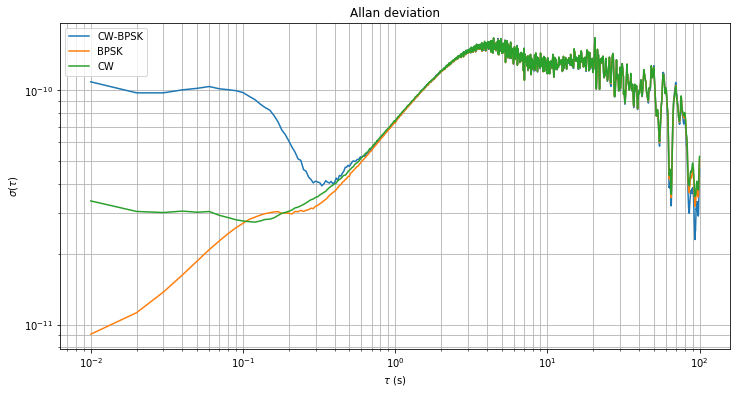

In [5]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.loglog(taus, avars_diff, label = 'CW-BPSK')
plt.loglog(taus, avars_bpsk, label = 'BPSK')
plt.loglog(taus, avars_cw, label = 'CW')
plt.xlabel('$\\tau$ (s)')
plt.ylabel('$\\sigma(\\tau)$')
plt.legend()
plt.grid(which = 'both')
plt.title('Allan deviation');